In [4]:
!pip install yfinance pypfopt scipy -q

ERROR: Could not find a version that satisfies the requirement pypfopt (from versions: none)
ERROR: No matching distribution found for pypfopt


# SELECIÓN ACTIVOS PORTAFOLIO B

In [ ]:
!pip install PyPortfolioOpt

import numpy as np
import pandas as pd
import yfinance as yf

from datetime import datetime, timedelta

from pypfopt import risk_models, EfficientFrontier, black_litterman, objective_functions
from scipy.stats import norm, t as student_t

# Para ver todos los decimales
pd.set_option("display.float_format", lambda x: f"{x:,.6f}")

In [6]:
# ============================================
# 1. DEFINIR UNIVERSO Y CATEGORÍAS
# ============================================

tickers = [
    # Acciones
    "AAPL","MSFT","GOOGL","AMZN","TSLA","NVDA","JPM","DIS","PFE","KO",
    # ETFs renta variable
    "SPY","QQQ","EEM","EWZ","VGK",
    # Renta fija
    "TBIL","SHY","IEF","TLT","LQD","BND","TIP",
    # Diversificadores
    "GLD","SLV","USO","VNQ","BTC-USD","ETH-USD"
]

# Clasificación por tipo (ajusta si quieres)
equity = ["AAPL","MSFT","GOOGL","AMZN","TSLA","NVDA","JPM","DIS","PFE","KO",
          "SPY","QQQ","EEM","EWZ","VGK"]

fixed_income = ["TBIL","SHY","IEF","TLT","LQD","BND","TIP"]

diversifiers = ["GLD","SLV","USO","VNQ","BTC-USD","ETH-USD"]

equity_idx = [tickers.index(t) for t in equity]
fixed_idx  = [tickers.index(t) for t in fixed_income]
div_idx    = [tickers.index(t) for t in diversifiers]


In [7]:
# ============================================
# 2. DESCARGA DE DATOS
# ============================================

# Puedes fijar explícitamente la fecha de inicio si el profe la dio.
# Aquí uso "5y" hacia atrás desde hoy para simplificar.
data = yf.download(tickers, period="5m")["Close"].dropna(how="all")
data = data.ffill().dropna(how="any")  # rellenar huecos y limpiar

# Retornos diarios logarítmicos (puedes usar pct_change si prefieres)
rets = np.log(data / data.shift(1)).dropna()
rets.tail()


/tmp/ipython-input-67932643.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period="5y")["Close"].dropna(how="all")
[*********************100%***********************]  28 of 28 completed


Ticker,AAPL,AMZN,BND,BTC-USD,DIS,EEM,ETH-USD,EWZ,GLD,GOOGL,...,SHY,SLV,SPY,TBIL,TIP,TLT,TSLA,USO,VGK,VNQ
Date,,,,,,,,,,,,,,,,,,,,,
2025-11-21,0.019490,0.016217,0.002418,-0.017950,0.015267,-0.000188,-0.023611,0.004067,-0.001549,0.034666,...,0.001205,-0.010540,0.009912,0.000400,0.002345,0.003021,-0.010530,-0.012191,0.015160,0.016094
2025-11-22,0.000000,0.000000,0.000000,-0.005212,0.000000,0.000000,0.000690,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2025-11-23,0.000000,0.000000,0.000000,0.025159,0.000000,0.000000,0.012235,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2025-11-24,0.016186,0.025014,0.001743,0.000000,-0.022695,0.010491,0.000000,0.005294,0.015720,0.061225,...,0.000120,0.028937,0.014611,0.000000,0.000450,0.005682,0.066017,0.016032,-0.002532,0.002676
2025-11-25,0.000000,0.000000,0.000000,0.015015,0.000000,0.000000,0.049560,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [8]:
# ============================================
# 3. DEFINIR VENTANA DE PORTAFOLIO B
#    ÚLTIMOS 15 DÍAS PARA REBALANCEO DIARIO
# ============================================

# Últimos 15 días hábiles en el dataset
n_days_rebal = 15
rebalance_start_date = rets.index[-n_days_rebal]   # primer día de la quincena final

rets_estimation = rets[rets.index < rebalance_start_date]  # ventana histórica para estimar
rets_B          = rets[rets.index >= rebalance_start_date] # ventana donde se aplica Portafolio B

print("Ventana estimación:", rets_estimation.index[0], "→", rets_estimation.index[-1])
print("Ventana Portafolio B:", rets_B.index[0], "→", rets_B.index[-1])


Ventana estimación: 2022-08-10 00:00:00 → 2025-11-10 00:00:00
Ventana Portafolio B: 2025-11-11 00:00:00 → 2025-11-25 00:00:00


In [10]:
# ============================================
# 4. ESTIMACIÓN Σ (COVARIANZA) Y PRIORS PARA BL
# ============================================

from pypfopt import black_litterman

# Covarianza muestral anualizada
Sigma = risk_models.sample_cov(rets_estimation, frequency=252)

# Número de activos
n = len(tickers)

# "Market caps" ficticios (puedes sustituitlos por reales si quieres)
# La función solo necesita proporciones relativas.
mkt_caps = pd.Series(np.ones(n), index=tickers)

# Parámetro de aversión al riesgo (puedes jugar con esto)
delta = 2.5

# 4.1 Retornos de equilibrio π (priors) según Black–Litterman
pi = black_litterman.market_implied_prior_returns(
    market_caps=mkt_caps,
    cov_matrix=Sigma,
    risk_aversion=delta
)

pi

,0
Ticker,
AAPL,"10,096.494360"
AMZN,"1,715.424689"
BND,"1,577.836993"
BTC-USD,"92,059.747990"
DIS,"5,594.983807"
EEM,"2,647.457160"
ETH-USD,"14,536.350976"
EWZ,"1,020.450387"
GLD,"4,412.946550"


In [11]:
# ============================================
# 5. OPINIONES (VIEWS) PARA BLACK–LITTERMAN
# ============================================

# EJEMPLO: edita a tu gusto con tus opiniones macro / de noticias

P_list = []
Q_list = []

# 1) QQQ supera a SPY por 2% anual
row = np.zeros(n)
row[tickers.index("QQQ")] = 1
row[tickers.index("SPY")] = -1
P_list.append(row)
Q_list.append(0.02)

# 2) GLD supera a USO por 1%
row = np.zeros(n)
row[tickers.index("GLD")] = 1
row[tickers.index("USO")] = -1
P_list.append(row)
Q_list.append(0.01)

# 3) EEM rinde ~1% menos que SPY
row = np.zeros(n)
row[tickers.index("EEM")] = 1
row[tickers.index("SPY")] = -1
P_list.append(row)
Q_list.append(-0.01)

P = np.vstack(P_list)
Q = np.array(Q_list)

# Matriz de incertidumbre de las opiniones (diagonal)
Omega = np.diag([0.0004, 0.0004, 0.0004])

# Construimos el modelo BL usando:
# - covarianza Sigma
# - priors pi (ya calculados en el bloque 4)
# - views P, Q, Omega
bl_model = black_litterman.BlackLittermanModel(
    cov_matrix=Sigma,
    pi=pi,
    P=P,
    Q=Q,
    omega=Omega,
    tau=0.05
)

# Retornos esperados ajustados BL (anualizados)
mu_bl = bl_model.bl_returns()
mu_bl


,0
Ticker,
AAPL,"9,980.070417"
AMZN,"1,678.187155"
BND,"1,697.108560"
BTC-USD,"91,842.134805"
DIS,"4,830.425122"
EEM,"2,807.492972"
ETH-USD,"13,690.096424"
EWZ,998.457274
GLD,"4,522.742342"


In [19]:
# ============================================
# MÉTRICAS PARA JUSTIFICAR EL UNIVERSO REDUCIDO
# ============================================

import numpy as np
import pandas as pd
import yfinance as yf

# Todos los activos originalmente
all_tickers = [
    "AAPL","MSFT","GOOGL","AMZN","TSLA","NVDA","JPM","DIS","PFE","KO",
    "SPY","QQQ","EEM","EWZ","VGK",
    "TBIL","SHY","IEF","TLT","LQD","BND","TIP",
    "GLD","SLV","USO","VNQ","BTC-USD","ETH-USD"
]

# Descargar precios 5 años
data_all = yf.download(all_tickers, period="5y")["Close"].dropna()
rets_all = data_all.pct_change().dropna()

# --- 1) Volatilidad anualizada ---
vol = rets_all.std() * np.sqrt(252)

# --- 2) Retorno anualizado ---
mean_ret = (1 + rets_all.mean())**252 - 1

# --- 3) Sharpe individual usando TBIL como tasa RF ---
rf_daily = rets_all["TBIL"].mean()
sharpe = (rets_all.mean() - rf_daily) / rets_all.std()
sharpe = sharpe.replace([np.inf, -np.inf], np.nan)

# --- 4) Máximo Drawdown individual ---
def max_drawdown_series(series):
    cum = (1 + series).cumprod()
    peak = cum.cummax()
    dd = (cum - peak) / peak
    return dd.min()

drawdowns = rets_all.apply(max_drawdown_series)

# --- 5) Correlación con SPY (benchmark diversificación) ---
corr_spy = rets_all.corrwith(rets_all["SPY"])

# Tabla resumen
summary = pd.DataFrame({
    "Mean_return_ann": mean_ret,
    "Vol_ann": vol,
    "Sharpe": sharpe,
    "Max_Drawdown": drawdowns,
    "Corr_SPY": corr_spy
}).sort_values("Vol_ann", ascending=False)

summary


/tmp/ipython-input-972318632.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_all = yf.download(all_tickers, period="5y")["Close"].dropna()
[*********************100%***********************]  28 of 28 completed


,Mean_return_ann,Vol_ann,Sharpe,Max_Drawdown,Corr_SPY
Ticker,,,,,
ETH-USD,0.431458,0.651731,0.030280,-0.637877,0.403749
TSLA,0.328080,0.611891,0.024525,-0.650524,0.560981
NVDA,1.339831,0.520708,0.097489,-0.409923,0.677688
BTC-USD,0.678272,0.495128,0.060131,-0.353055,0.352980
AMZN,0.223625,0.342180,0.028760,-0.434867,0.712987
GOOGL,0.404097,0.314753,0.058830,-0.316596,0.639444
USO,0.029924,0.307063,-0.003321,-0.260493,0.215336
DIS,0.039071,0.297643,-0.001555,-0.365237,0.588583
SLV,0.360495,0.289252,0.057138,-0.195906,0.300573


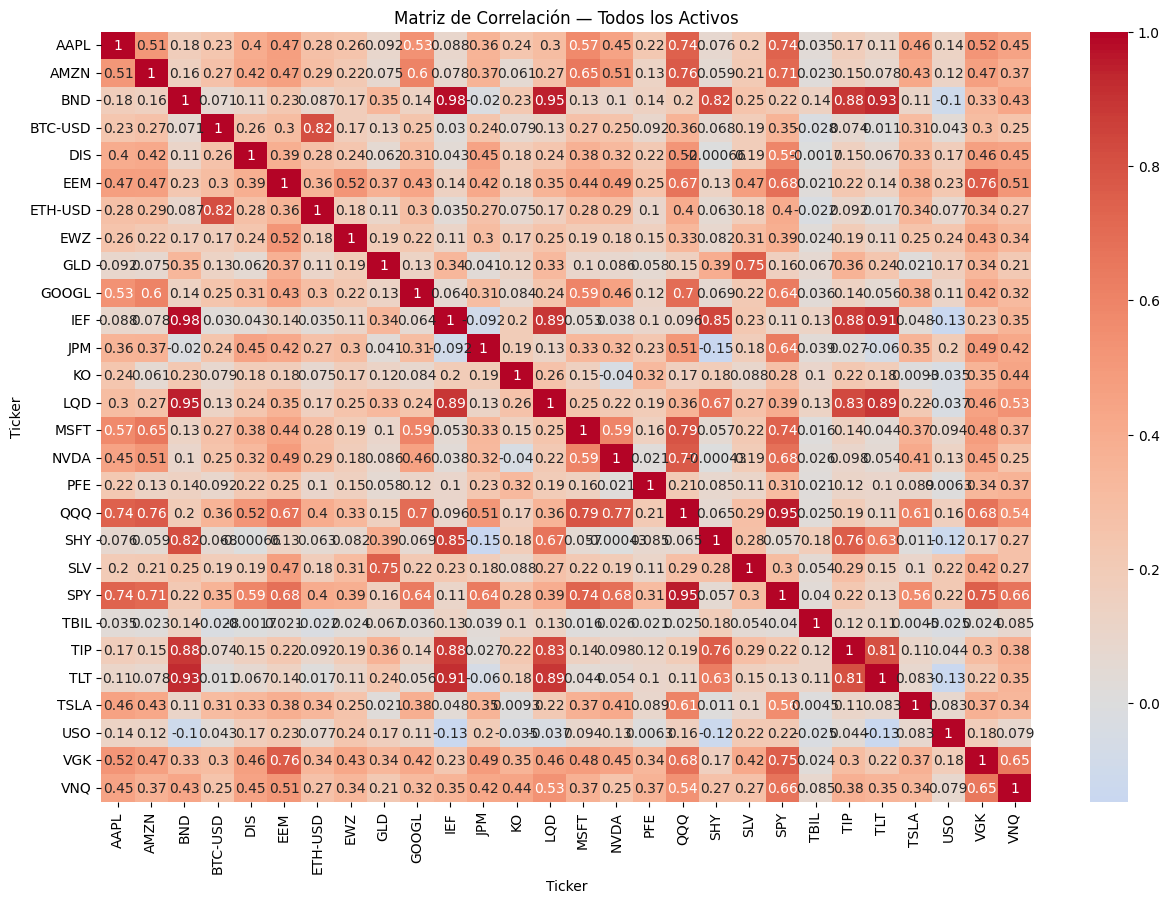

In [21]:
# ============================================
# MATRIZ DE CORRELACIÓN COMPLETA
# ============================================

corr_matrix = rets_all.corr()

# Ordenada para que puedas interpretarla mejor
corr_matrix_sorted = corr_matrix.loc[all_tickers, all_tickers]

corr_matrix_sorted

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, annot=True)
plt.title("Matriz de Correlación — Todos los Activos")
plt.show()
